In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostClassifier
from sklearn import tree
from sklearn.tree import _tree


import xgboost as xgb

SEED = 42

# Filename to save/load models

In [2]:
filename = '../models/test 65%/'

# Functions defining

In [3]:
def print_scores(y_true, y_pred):
    print('ROCAUC score:',roc_auc_score(y_true, y_pred).round(4))
    print('Accuracy score:',accuracy_score(y_true, y_pred).round(4))
    print('F1 score:',f1_score(y_true, y_pred).round(4))
    print('Precision score:',precision_score(y_true, y_pred).round(4))
    print('Recall:',recall_score(y_true, y_pred).round(4))

def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score, y_pred

def tune_model(model, param_grid, n_iter, X_train, y_train):
    grid = RandomizedSearchCV(model, param_grid, verbose=20,
        scoring='roc_auc', cv=3, n_iter=n_iter)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    return best_model

# Load data

In [4]:
df = pd.read_csv('../data/Parameters_90%stability.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
df.shape

(372, 1411)

# Look at target variable

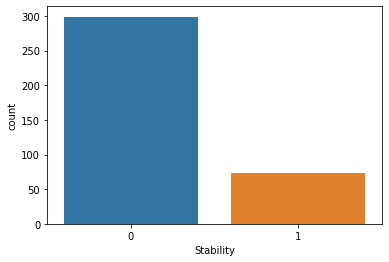

In [6]:
sns.countplot(data=df, x='Stability')
plt.show()

In [7]:
SI = len(df[df['Stability']==1])/len(df) * 100
print("The Stability Index is: SI =",round(SI, 4), "%")

The Stability Index is: SI = 19.6237 %


Imbalanced dataset

# Split train - test

In [8]:
from sklearn.model_selection import train_test_split

# Load X and Y 
X = df.drop(['Stability'], axis = 1)
y = df['Stability']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.35,
                                                stratify=y, random_state=SEED)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [9]:
print('train',x_train.shape)
print('test',x_test.shape)

train (241, 1410)
test (131, 1410)


In [10]:
SI_train = len(y_train[y_train['Stability']==1])/len(y_train) * 100
print("The Stability Index on TRAIN SET is: SI =",round(SI_train, 4), "%")

SI_test = len(y_test[y_test['Stability']==1])/len(y_test) * 100
print("The Stability Index on TEST SET is: SI =",round(SI_test, 4), "%")

The Stability Index on TRAIN SET is: SI = 19.5021 %
The Stability Index on TEST SET is: SI = 19.8473 %


# _Feature_names_ and _class_names_

In [11]:
class_names = y_train['Stability'].unique().astype(str)
feature_names = x_train.columns.values

# Normalize data

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

X_train = pd.DataFrame(X_train, columns=x_train.columns)
X_train.index = x_train.index

X_test = pd.DataFrame(X_test, columns=x_test.columns)
X_test.index = x_test.index

## SVM

In [13]:
try:
    
    # load the model from disk
    best_svc = pickle.load(open(filename+'/svc_model.sav', 'rb'))

except FileNotFoundError:

    # =================
    # SVC
    # =================

    param_grid_svc = {'C': [0.001, 0.005, 0.01, 0.02, 0.05, 0.08, 1, 1.5, 2, 2.5, 3, 5, 10, 12, 20, 25, 50],
                'gamma': [0.002, 0.003, 0.004, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5],
                'kernel': ['rbf', 'linear']
    }

    svc = SVC(random_state=SEED)
    best_svc = tune_model(svc, param_grid_svc, 1000, X_train, y_train.values.ravel())
    score, y_pred_svc = run_model(best_svc, X_train, y_train.values.ravel(),
        X_test, y_test.values.ravel())

    pickle.dump(best_svc, open(filename+'/svc_model.sav', 'wb'))   


In [14]:
print(best_svc)

SVC(C=0.02, gamma=0.002, kernel='linear', random_state=42)


In [15]:
y_pred_svc = best_svc.predict(X_test)
print_scores(y_test, y_pred_svc)

ROCAUC score: 0.7262
Accuracy score: 0.8626
F1 score: 0.5909
Precision score: 0.7222
Recall: 0.5


# Feature Selection using _Boruta_

In [72]:
from boruta import BorutaPy

rfc = RandomForestClassifier(random_state=SEED)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=SEED, max_iter=10)
boruta_selector.fit(np.array(X_train), np.array(y_train).reshape(-1,))  
print("Ranking: ",boruta_selector.ranking_)          
print("No. of significant features: ", boruta_selector.n_features_) 

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	0
Tentative: 	115
Rejected: 	1295
Iteration: 	9 / 10
Confirmed: 	5
Tentative: 	110
Rejected: 	1295


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	47
Rejected: 	1295
Ranking:  [ 134  663  223 ...  538 1247  956]
No. of significant features:  5


In [81]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(X_train.columns, 
                         boruta_selector.ranking_, 
                         boruta_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    if(feat[2]==True):
        print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Gamma_IG3PS               Rank: 1,  Keep: True
Feature: Gamma_TPI                 Rank: 1,  Keep: True
Feature: Gamma_ALATA_L             Rank: 1,  Keep: True
Feature: sigma_km_product2_ALCD26xi Rank: 1,  Keep: True
Feature: sigma_km_product2_GF6PTA  Rank: 1,  Keep: True
